# DZ «Элементарные методы анализа временных рядов»

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# Series
female_births = pd.read_csv("C:/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/daily-total-female-births-in-cal.csv")
closing_of_dowjones = pd.read_csv("C:/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/weekly-closings-of-the-dowjones-.csv")
air_temperature = pd.read_csv("C:/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/mean-monthly-air-temperature-deg.csv")
airline_passengers = pd.read_csv("C:/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/international-airline-passengers.csv")
boston_armed_robberies_j = pd.read_csv("C:/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/monthly-boston-armed-robberies-j.csv")
sales_of_company_x_jan_6 = pd.read_csv("C:\/Users/kimta/Documents/Data Science/временные ряды/1._Лекция_tsml/Series/monthly-sales-of-company-x-jan-6.csv")

In [4]:
all_series = {
    "Daily total female births in cal": female_births["Count"],
    "Weekly closings of the Dow Jones": closing_of_dowjones["Close"],
    "Mean monthly air temperature": air_temperature["Deg"],
    "International airline passengers": airline_passengers["Count"],
    "Monthly Boston armed robberies j": boston_armed_robberies_j["Count"],
    "Monthly sales of company X jan 6": sales_of_company_x_jan_6["Count"]
}

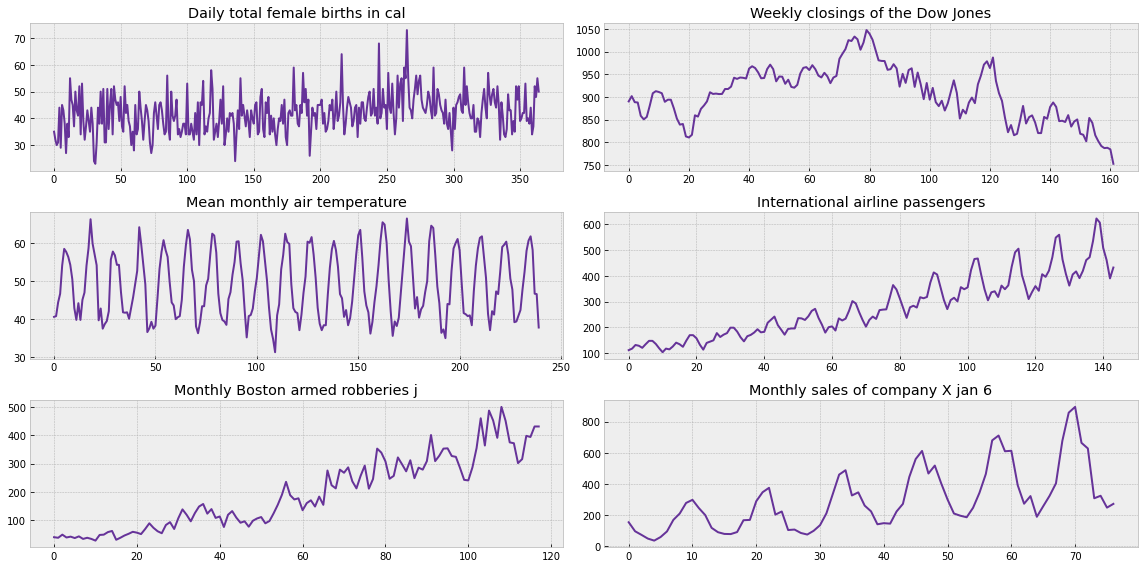

In [5]:
# Визуализация данных
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='rebeccapurple')
        ts_ax.set_title(key)
        
    plt.tight_layout()
#     plt.show()


Возьмем два ряда Daily total female births in cal и Monthly Boston armed robberies j

## Ряд Daily total female births in cal

### Скользящее среднее

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

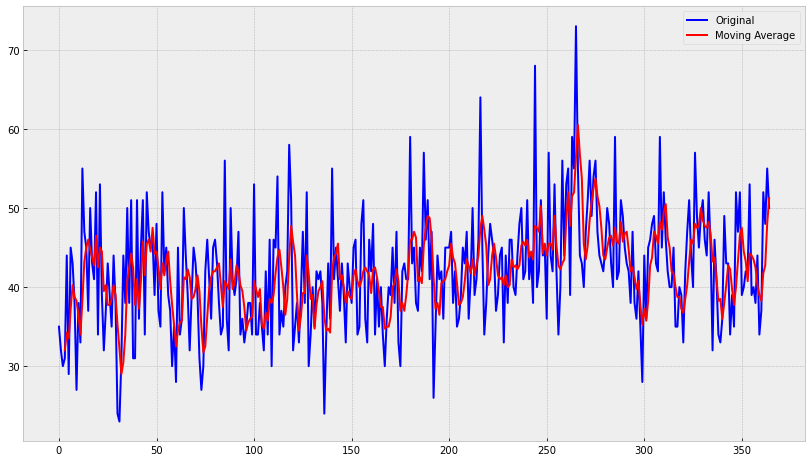

In [12]:
ma = moving_average(female_births["Count"], 4)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='Original')
    plt.plot(ma, color='red', linewidth='2', label='Moving Average')
    plt.legend()

### Экспоненциальное сглаживание

In [8]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

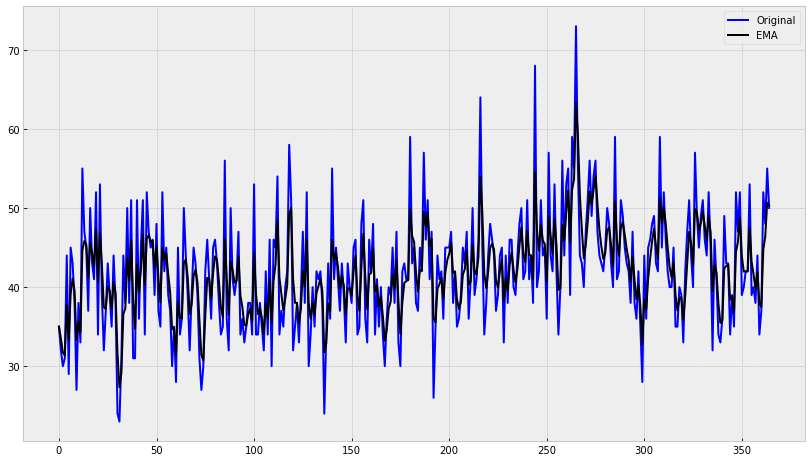

In [13]:
ema = exponential_moving_average(female_births["Count"], 0.5)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='Original')
#     plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

Поскольку для этого временного ряда отсутствует тренд и сезоннность можем применить простое экспоненциальное сглаживание

### Оптимизируем параметры для EMA ряда Daily total female births in cal с помощью RMSE и кросс валидации

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [20]:
# RMSE
series_1 = female_births["Count"]
train, test, val = series_1[:100], series_1[100:150], series_1[150:]

In [21]:
def mse(X):
    alpha = X
    result = exponential_moving_average(train, alpha)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [68]:
opt = minimize(mse, x0=[0,], method="L-BFGS-B", bounds = ((0.3, 1),))

In [69]:
alpha_opt = opt.x
print(opt)

      fun: 26858.66169920785
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1306.13116267])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.3])


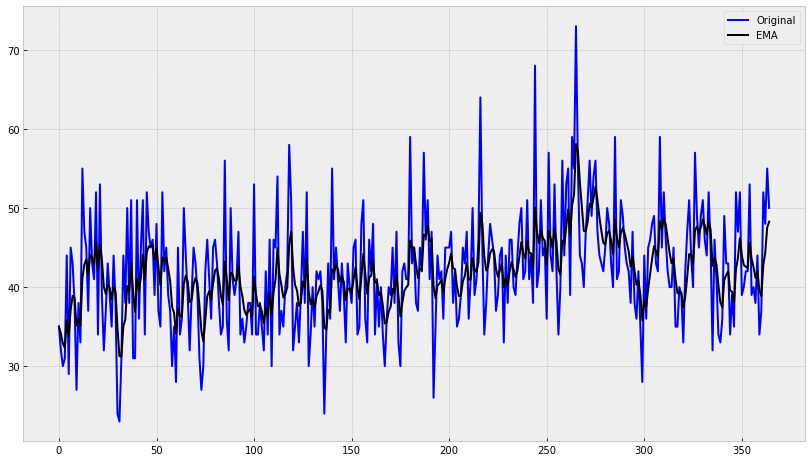

In [70]:
ema_2 = exponential_moving_average(female_births["Count"], alpha_opt)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='Original')
    plt.plot(ema_2, color='black', linewidth='2', label='EMA')
    plt.legend()

In [71]:
# Кросс-валидация
train, val = series_1[:100], series_1[100:]

In [72]:
def mse_cross_val(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = exponential_moving_average(train_split_ts, alpha)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [73]:
opt = minimize(mse_cross_val, x0=[0,], method="Nelder-Mead", bounds = ((0.3, 1),))

69.61333333333333------------
69.24195867151381------------
68.87939620199671------------
68.52541308058326------------
67.84228515202449------------
67.1908362833066------------
65.97648438145792------------
64.87023116059613------------
62.93972107894151------------
61.32533316651857------------
58.819057240788204------------
57.002849871196425------------
54.61599156237768------------
53.145723223000594------------
51.436718135008455------------
50.52353240283494------------
49.98956443666109------------
50.5752766346183------------
50.5752766346183------------
50.08153420281837------------
50.173451217362015------------
49.996956929240774------------
50.050914980866054------------
49.98416424014522------------
49.996956929240774------------
49.98465535924381------------
49.98822036334949------------
49.98384956225698------------
49.98465535924381------------
49.98386583026712------------
49.98411340932045------------
49.98382255554866------------
49.98386583026712------------
49.98

C:\Users\kimta\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [74]:
alpha_opt_1 = opt.x
print(opt)

 final_simplex: (array([[0.0925   ],
       [0.0925625]]), array([49.98382256, 49.98382273]))
           fun: 49.98382255554866
       message: 'Optimization terminated successfully.'
          nfev: 36
           nit: 18
        status: 0
       success: True
             x: array([0.0925])


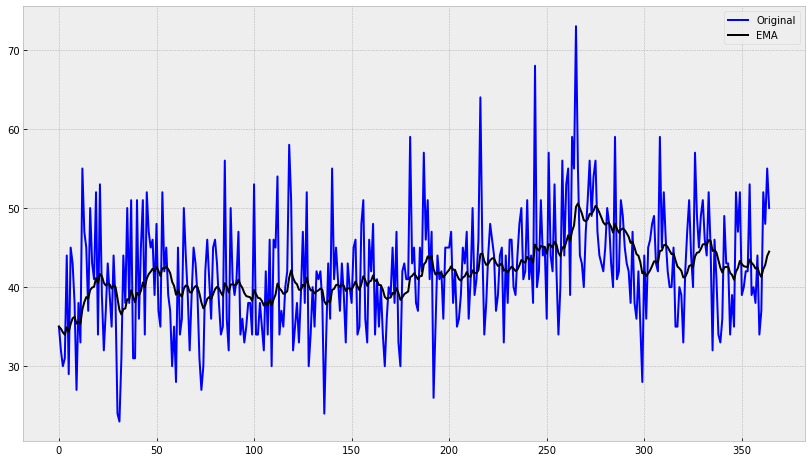

In [75]:
ema_3 = exponential_moving_average(female_births["Count"], alpha_opt_1)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='Original')
    plt.plot(ema_3, color='black', linewidth='2', label='EMA')
    plt.legend()

## Ряд Monthly Boston armed robberies j

### Скользящее среднее

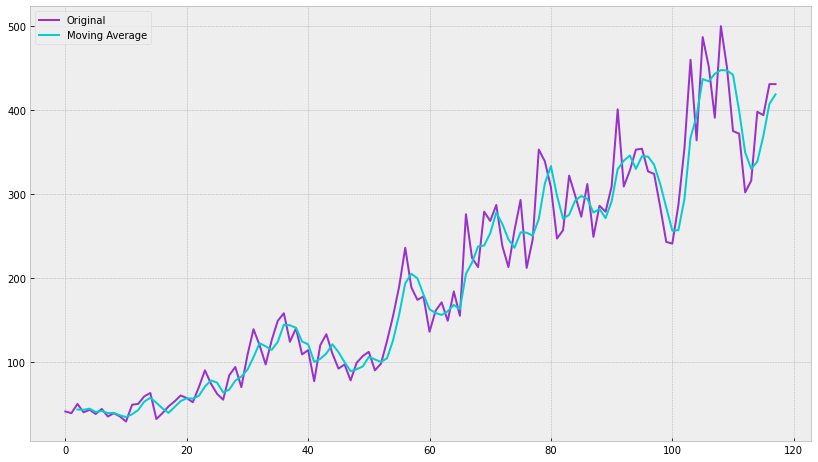

In [30]:
ma = moving_average(boston_armed_robberies_j["Count"], 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(boston_armed_robberies_j["Count"], color='darkorchid',label='Original')
    plt.plot(ma, color='darkturquoise', label='Moving Average')
    plt.legend()

Поскольку для этого временного ряда присутствует тренд и нет сезоннности можем применить двойное экспоненциальное сглаживание

In [31]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [32]:
def plot_dema(alpha, beta):
    dema = double_ema(boston_armed_robberies_j["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(boston_armed_robberies_j["Count"], color='blue',label='Original')
        plt.plot(dema, color='yellow', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

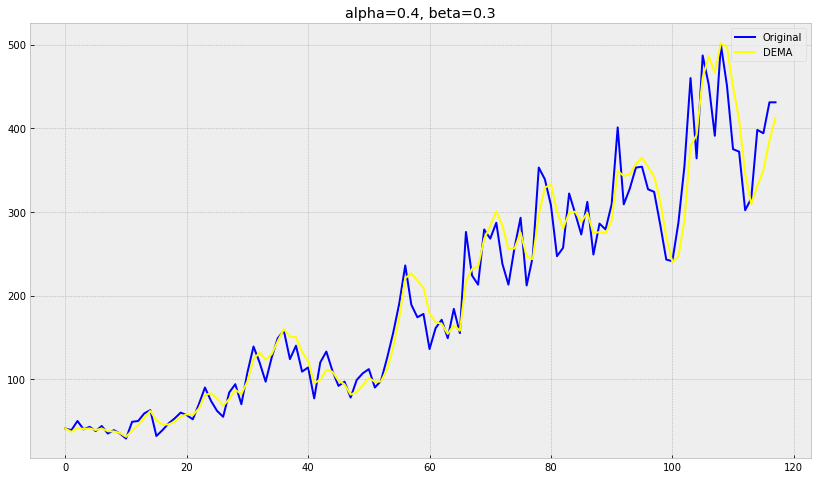

In [79]:
plot_dema(0.4, 0.3)

### Оптимизируем параметры для EMA ряда Monthly Boston armed robberies j с помощью RMSE и кросс валидации

In [54]:
# RMSE
series_2 = boston_armed_robberies_j["Count"]
train, test, val = series_2[:60], series_2[60:70], series_2[70:]

In [55]:
def mse_2(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [56]:
opt = minimize(mse_2, x0=[0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [57]:
alpha_opt_2, beta_opt_2 = opt.x
print(opt)

      fun: 1776.276445972549
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373676e-05, -4.16455257e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 23
     njev: 35
   status: 0
  success: True
        x: array([0.16920375, 1.        ])


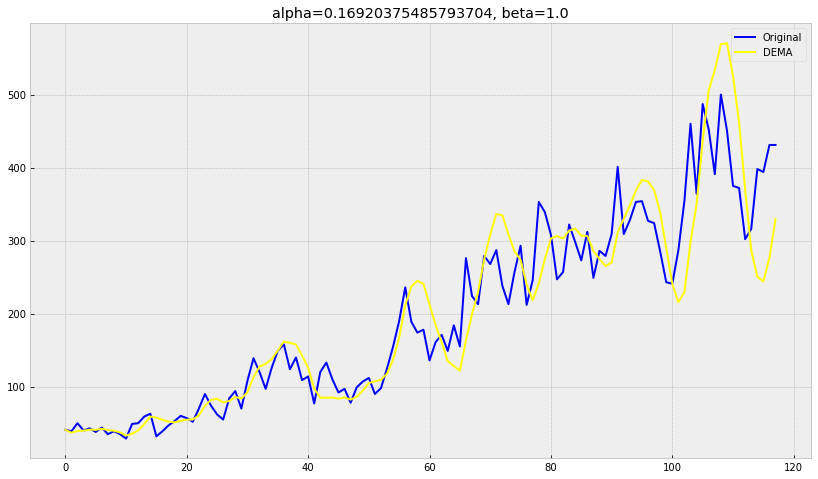

In [58]:
plot_dema(alpha_opt_2, beta_opt_2)

In [59]:
# Кросс-валидация
train, val = series_1[:65], series_1[65:]

In [60]:
def mse_cross_val_2(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [61]:
opt = minimize(mse_cross_val_2, x0=[0,0], method="Nelder-Mead", bounds = ((0, 1),(0, 1)))

C:\Users\kimta\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


8466.25------------
8389.51610003249------------
8466.25------------
8389.777880742671------------
8314.161045212593------------
8239.77353494906------------
8239.00378466514------------
8164.687957508468------------
8021.152516630546------------
7846.119902350615------------
7774.083474361949------------
7553.409685732386------------
7269.955639632225------------
6875.916179378429------------
6626.077059876482------------
6109.8705209585------------
5614.5423801678335------------
4913.406181188173------------
4423.546698214227------------
3651.8928521763432------------
3107.914227127761------------
2422.8785326004263------------
1982.9981609510078------------
1488.9016716560582------------
1271.6901095793316------------
1054.152765216233------------
923.4941223190976------------
910.8123355309094------------
1147.6522589394808------------
974.8975495888535------------
1213.196793019576------------
936.8437721428958------------
892.2495341547952------------
915.4393760255622-----------

In [62]:
alpha_opt_3, beta_opt_3 = opt.x
print(opt)

 final_simplex: (array([[0.22840545, 0.09313272],
       [0.22832227, 0.0931757 ],
       [0.22841377, 0.0931519 ]]), array([118.83742383, 118.83742471, 118.83742501]))
           fun: 118.83742383326211
       message: 'Optimization terminated successfully.'
          nfev: 102
           nit: 54
        status: 0
       success: True
             x: array([0.22840545, 0.09313272])


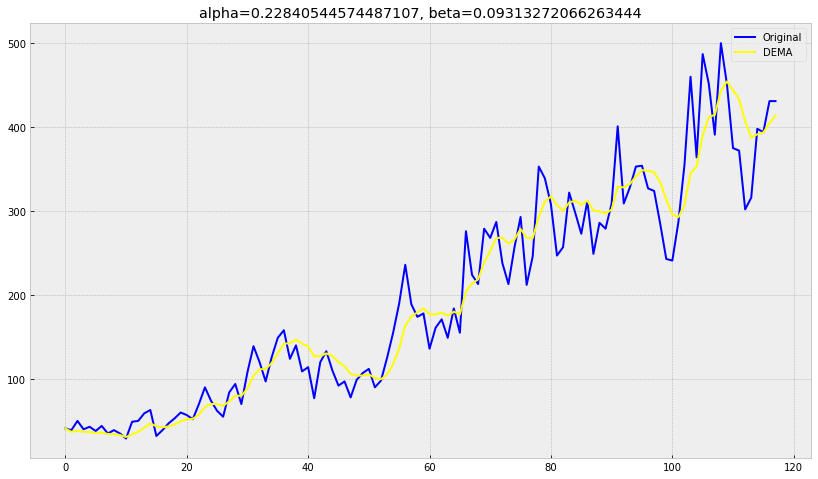

In [63]:
plot_dema(alpha_opt_3, beta_opt_3)

Мы брали два ряда Daily total female births in cal и Monthly Boston armed robberies j


Ряд Daily total female births in cal - отсутствует тренд и сезоннность - можем применить простое экспоненциальное сглаживание

Monthly Boston armed robberies j - присутствует тренд и нет сезоннности - можем применить двойное экспоненциальное сглаживание